<a href="https://colab.research.google.com/github/Tommy-Gozali/demand-forecast/blob/main/main_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skforecast

import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from google.colab import drive

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.options.plotting.backend = "plotly"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data_science_portfolio/power_load_forecast/

Mounted at /content/drive
/content/drive/MyDrive/data_science_portfolio/power_load_forecast


In [ ]:
df = pd.read_csv("power_load_BE_elia_15M_2015_2024.csv", delimiter = ";", on_bad_lines="skip")

In [ ]:
df = pd.read_csv("power_load_BE_elia_15M_2015_2024.csv", delimiter = ";", on_bad_lines="skip")
df = df[df["Datetime"].str.contains("2023|2022")]

In [ ]:
clean_start_date = "2021-11-01"
clean_end_date   = "2023-06-23"

In [ ]:
def normalize_data(df: pd.DataFrame,
                   start_date: str,
                   end_date  : str,
                   offset_rolling_feature_in_h: int):

  real_start_date = str(pd.to_datetime(start_date, format = "%Y-%m-%d") - pd.Timedelta(offset_rolling_feature_in_h, "H"))[:10]
  real_end_date   = end_date
  date_range = f"{real_start_date}:{real_end_date}"
  df.index = pd.to_datetime(df["Datetime"], utc = True)
  df = df.drop(columns = ["Datetime", "Resolution code"]).sort_index()
  df = df.loc[real_start_date:real_end_date]
  return df


In [ ]:
clean_data = ["2021-11-01:2023-06-23","2015-01-01:2021-10-31 01:45:00"
hour_in_week = 24*7
start_date   = "2022-06-01"
end_date     = "2023-06-15"
df_2023 = normalize_data(df = df, start_date= start_date, end_date=end_date,
               offset_rolling_feature_in_h = hour_in_week )

In [ ]:
#df_2023.index = pd.to_datetime(df_2023["Datetime"], utc = True)
#df_2023 = df_2023.drop(columns = ["Datetime", "Resolution code"]).sort_index()
#df_2023 = df_2023.loc["2023-01-01":"2023-03-01"]
missing_date = pd.date_range(start = df_2023.index[0],
                             end   = df_2023.index[-1] ).difference(df_2023.index)
missing_date

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='D')

In [ ]:
def find_bad_float_data(series):
  bad_rows = []
  for index, row in enumerate(series):
    try:
      float(row)
    except:
      bad_rows.append({index:row})

  return bad_rows

In [ ]:
df_2023.apply(find_bad_float_data)

,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast


In [ ]:
#df_2023["Most recent forecast"][23048] = 7167.2810582

In [ ]:
df_2023 = df_2023.apply(lambda x : x.astype(float))

In [ ]:
def return_missing_index(series):
  missing_index = np.where(series.isna())
  return [np.amin(missing_index), np.amax(missing_index)]

In [ ]:
missing_list = []
for col in df_2023.columns:
  try:
    missing_list.append({col:return_missing_index(df_2023[col])})
  except:
    print(col)


Total Load
Most recent forecast
Most recent P10
Most recent P90
Day-ahead 6PM forecast
Day-ahead 6PM P10
Day-ahead 6PM P90
Week-ahead forecast


In [ ]:
df_2023_interp = df_2023.interpolate()

In [ ]:
data = df_2023_interp#.loc["2023-01-01 00:00:00":"2023-06-01 00:00:00"]
data = data.resample("H").mean()
data = data.rename(columns = {"Total Load":"y"})

data["month"] = data.index.month
data["dayofweek"] = data.index.dayofweek
data["hour"] = data.index.hour

In [ ]:
hour_in_day   = 24
hour_in_week  = 24*7
hour_in_month = hour_in_week * 4
folds = 8
steps = hour_in_week * 8

data_train_index = data.index[:-steps]
data_test_index  = data.index[-steps:]

print(f"Train dates : {data_train_index.min()} --- {data_train_index.max()}  (n={len(data_train_index)})")
print(f"Test dates  : {data_test_index.min()} --- {data_test_index.max()}  (n={len(data_test_index)})")

Train dates : 2022-05-25 00:00:00+00:00 --- 2023-04-20 23:00:00+00:00  (n=7944)
Test dates  : 2023-04-21 00:00:00+00:00 --- 2023-06-15 23:00:00+00:00  (n=1344)


In [ ]:
%run get_exog_data.ipynb

In [ ]:
brussel_longitude = 50.85
brussel_latitude  = 4.34
brussel_weather_data = OpenMeteoApi(brussel_longitude,
                                    brussel_latitude)
def get_start_end_date(date_list: list):
  return str(date_list[0])[:10], str(date_list[-1])[:10]

start_date_train, end_date_train = get_start_end_date(data_train_index)
start_date_test,  end_date_test  = get_start_end_date(data_test_index)
parameters = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "is_day"]#, "weather_code"]

In [ ]:
parameters_train = brussel_weather_data.initiate_parameters(start_date = start_date_train,
                                                            end_date = end_date_train,
                                                            parameters = parameters)
parameters_test = brussel_weather_data.initiate_parameters(start_date = start_date_test,
                                                            end_date = end_date_test,
                                                            parameters = parameters)
data[parameters] = brussel_weather_data.get_historical_forecast_data(parameters_train)\
    .combine_first(brussel_weather_data.get_historical_forecast_data(parameters_test))
"""
data_exog_wea_train, data_exog_wea_test = brussel_weather_data.get_historical_forecast_data(parameters_train),\
                                          brussel_weather_data.get_historical_forecast_data(parameters_test)
                                          """

'\ndata_exog_wea_train, data_exog_wea_test = brussel_weather_data.get_historical_forecast_data(parameters_train),                                          brussel_weather_data.get_historical_forecast_data(parameters_test)\n                                          '

In [ ]:
%run utils.ipynb

In [ ]:
import itertools

day = 1
day_in_week = 7
duration_list   = [day, day_in_week]
agg_method_list = ['mean', 'max', 'min']

duration_agg_method_combinations = list(itertools.product(duration_list, agg_method_list))

In [ ]:
fe = FeatureEngineering()
rolling_feature_df_list = []
for element in duration_agg_method_combinations:
  data_exog_rolled = fe.get_rolling_data(df = data,
                                    parameter = "temperature_2m",
                                    duration = element[0],
                                    duration_unit = "D",
                                    agg_method = element[1])
  rolling_feature_df_list.append(data_exog_rolled)

data_exog_rolled = pd.concat(rolling_feature_df_list, axis = 1)
data = pd.concat([data,data_exog_rolled], axis = 1)
rolled_parameters = data_exog_rolled.columns.tolist()

In [ ]:
data_train = data.loc[data_train_index].loc[start_date:end_date]
data_test  = data.loc[data_test_index].loc[start_date:end_date]
data = data.loc[start_date:end_date]

In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [ ]:
data_train.isna().sum() + data_test.isna().sum()

y                                  0
Most recent forecast               0
Most recent P10                    0
Most recent P90                    0
Day-ahead 6PM forecast             0
Day-ahead 6PM P10                  0
Day-ahead 6PM P90                  0
Week-ahead forecast                0
month                              0
dayofweek                          0
hour                               0
temperature_2m                     0
relative_humidity_2m               0
dew_point_2m                       0
apparent_temperature               0
is_day                             0
temperature_2m_rolling_mean_1_D    0
temperature_2m_rolling_max_1_D     0
temperature_2m_rolling_min_1_D     0
temperature_2m_rolling_mean_7_D    0
temperature_2m_rolling_max_7_D     0
temperature_2m_rolling_min_7_D     0
dtype: int64

In [ ]:
"""
# Lags used as predictors
lags_grid = [hour_in_day, hour_in_week, hour_in_month]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
       'max_depth': [5, 10, 15]
}

results = grid_search_forecaster(
              forecaster         = forecaster,
              y                  = data['y'],
              exog               = data[exog_vars],
              param_grid         = param_grid,
              lags_grid          = lags_grid,
              steps              = steps,
              refit              = False,
              metric             = 'mean_absolute_percentage_error',
              initial_train_size = len(data_train),
              fixed_train_size   = False,
              return_best        = True,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )
          """

"\n# Lags used as predictors\nlags_grid = [hour_in_day, hour_in_week, hour_in_month]\n\n# Regressor hyperparameters\nparam_grid = {\n    'n_estimators': [50, 100],\n       'max_depth': [5, 10, 15]\n}\n\nresults = grid_search_forecaster(\n              forecaster         = forecaster,\n              y                  = data['y'],\n              exog               = data[exog_vars],\n              param_grid         = param_grid,\n              lags_grid          = lags_grid,\n              steps              = steps,\n              refit              = False,\n              metric             = 'mean_absolute_percentage_error',\n              initial_train_size = len(data_train),\n              fixed_train_size   = False,\n              return_best        = True,\n              n_jobs             = 'auto',\n              verbose            = False,\n              show_progress      = True\n          )\n          "

In [ ]:
exog_vars = ["month", "dayofweek", "hour"] + parameters + rolled_parameters

# Create and train forecaster
# ==============================================================================

regressor  = RandomForestRegressor(max_depth=10, n_estimators=50)
regressor_name = str(regressor).split('()')[0]
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = hour_in_month
             )

forecaster.fit(y=data_train['y'], exog=data_train[exog_vars])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 2

In [ ]:

# Predictions
# ==============================================================================
predictions = forecaster.predict(steps = steps,
                                 exog  = data_test[exog_vars])
predictions.index = data_test.index
data_test[regressor_name] = predictions

In [ ]:
fig = data_test[["y", "Most recent forecast", regressor_name, "Week-ahead forecast"]].plot.line()
fig.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
for col in ["Most recent forecast",regressor_name , "Week-ahead forecast"]:
  error_mape = mean_absolute_percentage_error(
                  y_true = data_test['y'],
                  y_pred = data_test[col]
              )

  print(f"Test error (MAPE) for {col}: {error_mape*100}%")

Test error (MAPE) for Most recent forecast: 1.9637075161298527%
Test error (MAPE) for RandomForestRegressor(max_depth=10, n_estimators=50): 3.827643869742884%
Test error (MAPE) for Week-ahead forecast: 3.9306546808018568%


In [ ]:
# Backtesting
# ==============================================================================
regressor  = RandomForestRegressor(max_depth=10, n_estimators=50)
regressor_name = str(regressor).split('()')[0]
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = hour_in_month
             )
exog_vars = ["month", "dayofweek", "hour"] + parameters + rolled_parameters

metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['y'],
                          steps              = hour_in_week,
                          exog               = data[exog_vars],
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data_train),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 7776
Number of observations used for backtesting: 1344
    Number of folds: 8
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-06-01 00:00:00+00:00 -- 2023-04-20 23:00:00+00:00  (n=7776)
    Validation: 2023-04-21 00:00:00+00:00 -- 2023-04-27 23:00:00+00:00  (n=168)
Fold: 1
    Training:   2022-06-08 00:00:00+00:00 -- 2023-04-27 23:00:00+00:00  (n=7776)
    Validation: 2023-04-28 00:00:00+00:00 -- 2023-05-04 23:00:00+00:00  (n=168)
Fold: 2
    Training:   2022-06-15 00:00:00+00:00 -- 2023-05-04 23:00:00+00:00  (n=7776)
    Validation: 2023-05-05 00:00:00+00:00 -- 2023-05-11 23:00:00+00:00  (n=168)
Fold: 3
    Training:   2022-06-22 00:00:00+00:00 -- 2023-05-11 23:00:00+00:00  (n=7776)
    Validation: 2023-05-12 00:00:00+00:00 -- 2023-05-18 23:00:00+00:00  (n=168)
Fold: 4


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
predictions.index = data_test.index
data_test[regressor_name] = predictions
(f"Test error (MAPE) for {col}: {metric*100}%")

'Test error (MAPE) for Week-ahead forecast: 4.516683783885667%'

In [ ]:
fig = data_test.loc[:"2023-05-18 23:00:00+00:00"][["y", "Most recent forecast", regressor_name, "Week-ahead forecast"]].plot.line()
fig.show()

In [ ]:
def get_backtest_folds_periods(y: pd.Series,
                              steps: int,
                              initial_train_size: int,
                              ) -> pd.DataFrame:

  start_date_first_fold = y.index[initial_train_size:][0]

  n_folds = len(y.index[initial_train_size:])/hour_in_week

  fold_df = pd.DataFrame(columns=["fold_start_date", "fold_end_date"])

  if n_folds.is_integer():
    for fold_number in range(int(n_folds)):

      if fold_number == 0:
        start_date_fold = start_date_first_fold

      else:
        start_date_fold = end_date_fold + pd.Timedelta(1, "H")

      end_date_fold   = start_date_fold + pd.Timedelta(hour_in_week - 1, "H")

      fold_df.loc[fold_number] = [start_date_fold, end_date_fold]
      fold_df.index.anmes = ["fold_number"]

  else:
    print("n_folds is not integer")

  return fold_df

In [ ]:
df_backtest_fold_periods = get_backtest_folds_periods(y = data["y"],
                                                      steps = hour_in_week,
                                                      initial_train_size = len(data_train))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
forecasts_column = ["Most recent forecast", regressor_name , "Week-ahead forecast"]
def get_backtest_folds_metrics(df_backtest_fold_periods: pd.DataFrame,
                               data_test: pd.DataFrame) -> list[pd.DataFrame]:
  fold_df_list = []
  for fold in df_backtest_fold_periods.index:
    fold_start_date = df_backtest_fold_periods.loc[fold]["fold_start_date"]
    fold_end_date   = df_backtest_fold_periods.loc[fold]["fold_end_date"]

    data_ = data_test.loc[fold_start_date:fold_end_date]
    data_["fold_number"] = fold

    for forecast in forecasts_column:
      error_mape = mean_absolute_percentage_error(
                y_true = data_['y'],
                y_pred = data_[forecast]
              )
      data_[f"{forecast}_MAPE_in_%"] = error_mape
    fold_df_list.append(data_)
  return fold_df_list

In [ ]:
data_backtest_result = pd.concat(get_backtest_folds_metrics(df_backtest_fold_periods = df_backtest_fold_periods,
                           data_test = data_test.copy()))

In [ ]:
forecast_MAPEs     = [f"{forecast}_MAPE_in_%" for forecast in forecasts_column]
not_forecast_MAPEs = [col for col in data_backtest_result.columns if col not in forecast_MAPEs]

In [ ]:
data_backtest_result_melt = pd.melt(data_backtest_result,
                                    id_vars= not_forecast_MAPEs,
                                    value_vars= forecast_MAPEs,
                                    var_name = "forecast_name",
                                    value_name = "MAPEs")

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.box(data_backtest_result_melt, x="forecast_name", y="MAPEs")
fig.show()

In [ ]:
data_backtest_result.groupby(["fold_number"])[forecast_MAPEs].value_counts()

fold_number  Most recent forecast_MAPE_in_%  RandomForestRegressor(max_depth=10, n_estimators=50)_MAPE_in_%  Week-ahead forecast_MAPE_in_%
0            0.015892                        0.022723                                                        0.029053                         168
1            0.021901                        0.075463                                                        0.059545                         168
2            0.022685                        0.041075                                                        0.060076                         168
3            0.016854                        0.053020                                                        0.041536                         168
4            0.016749                        0.035565                                                        0.045593                         168
5            0.019637                        0.061756                                                        0.039307              

In [ ]:
forecasts_column

['Most recent forecast',
 'RandomForestRegressor(max_depth=10, n_estimators=50)',
 'Week-ahead forecast']

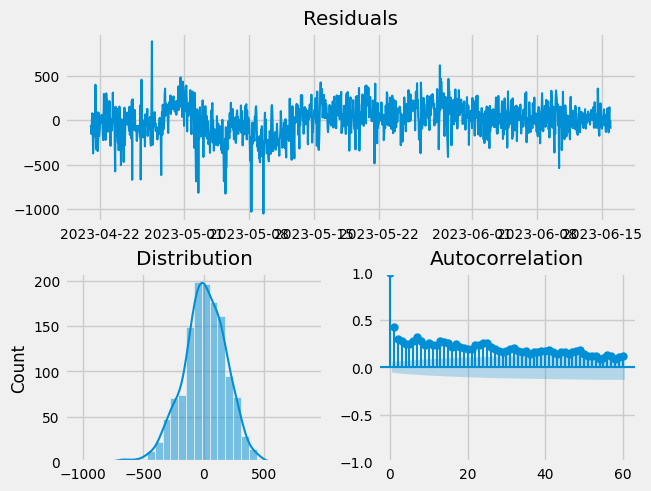

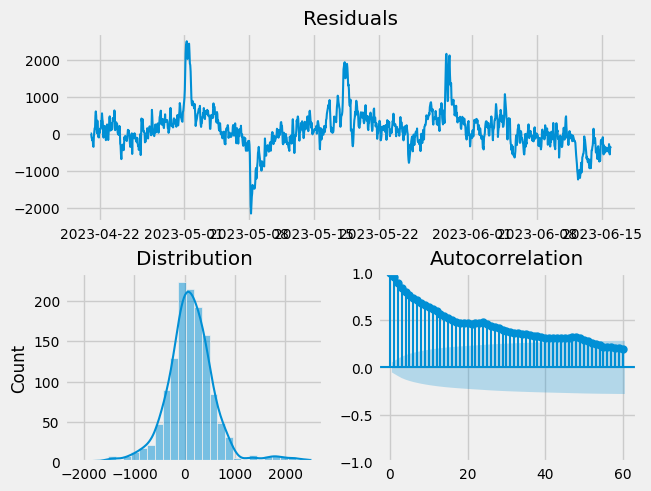

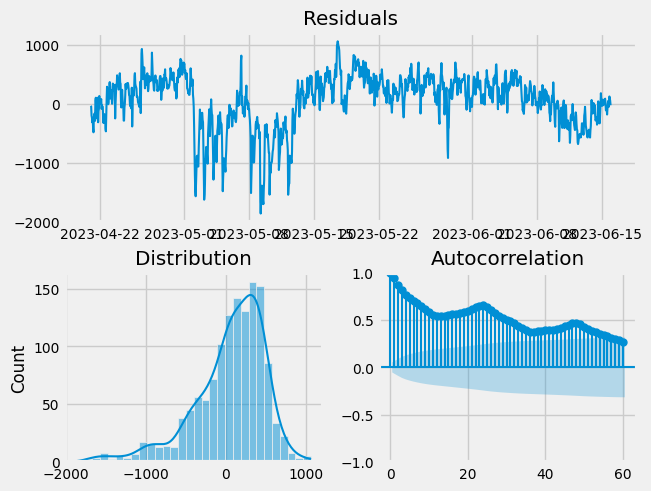

In [ ]:
from skforecast.plot import plot_residuals

for forecast in forecasts_column:
  residuals = data_backtest_result[forecast] - data_test['y']
  plot_residuals(residuals=residuals)

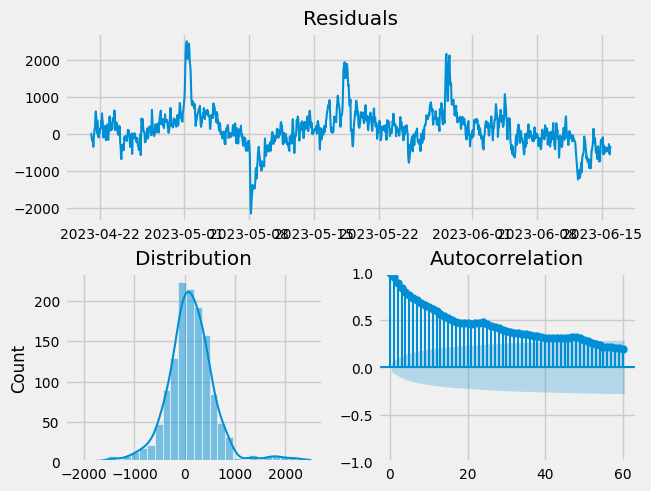

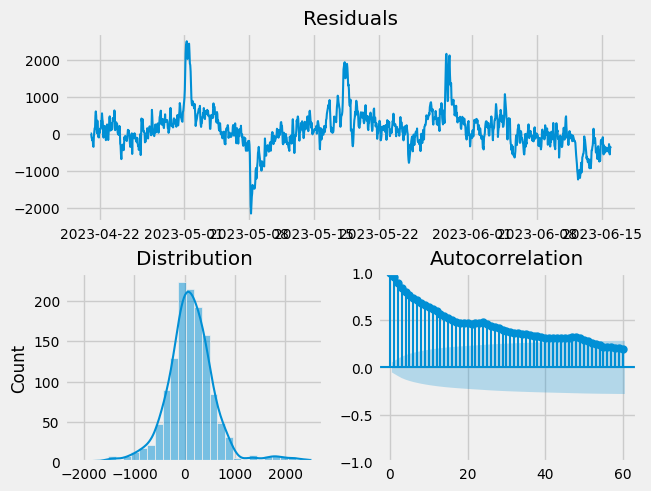

In [ ]:
from skforecast.plot import plot_residuals

residuals = predictions['pred'] - data_test['y']
plot_residuals(residuals=residuals)